#Breve explicación de la Notebook

Se utilizó la arquitectura InceptionV3 con Transfer Learning. Es decir,  incluyendo pesos pre - entrenados de ImageNet. Esto dió como resultado un considerablemente buen modelo, pero debido los resultados del F1 score comparados con otros modelos, se decidió no seguir indagando más en esta arquitectura. 

#Montaje e Importación de librerías

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.applications import InceptionV3
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras import models
from keras.models import Model, load_model
from keras.applications.inception_v3 import preprocess_input

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomFlip,Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import shutil
from tensorflow.keras.models import load_model, Model, Sequential
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from matplotlib import pyplot as plt
from keras import applications

In [4]:
!pip install -q --upgrade wandb
import wandb
from wandb.keras import WandbCallback
wandb.login()

     |████████████████████████████████| 1.6 MB 12.2 MB/s 
     |████████████████████████████████| 133 kB 50.5 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 170 kB 52.9 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./03. Utils')
import importlib
#importlib.reload(MyFunctions)
import MyFunctions

#Modelo

##Inputs

In [6]:
IMAGE_SIZE = (128,128)
NUM_CLASSES = 3 
BATCH_SIZE = 32 

In [7]:
df_train=pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/train0-7.xlsx")
df_test=pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/test0-7.xlsx")

In [8]:
train_datagen = ImageDataGenerator(validation_split = 0.2,rescale = 1./255)#,,horizontal_flip=True,rotation_range=40)
dir = '/content/drive/My Drive/Quinto_Anio/TESIS_Eugenia_Berrino/DS_comp_nodef'
train_batches = train_datagen.flow_from_dataframe( #tomamos info de un df
    df_train, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset = "training",
    seed=42,
    class_mode="categorical",)

Found 13951 validated image filenames belonging to 3 classes.


In [9]:
valid_batches = train_datagen.flow_from_dataframe(df_train, directory=dir,
                                            x_col='ImageID',y_col='Projection',
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            subset = "validation",
                                            seed=42,
                                            class_mode="categorical",)

Found 3487 validated image filenames belonging to 3 classes.


##Model Definition & Training

In [10]:
base_model = InceptionV3(weights= None, include_top=False, 
                                input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
base_model.trainable = False
add_model = Sequential()
add_model.add(base_model)
add_model.add(Flatten()) 
add_model.add(Dense(256, activation="relu"))  
add_model.add(Dense(NUM_CLASSES, activation='softmax'))

model = add_model
adam = Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 23,900,963
Trainable params: 2,098,179
Non-trainable params: 21,802,784
_________________________________________________________________


In [11]:
# Initialize wandb with your project name
run = wandb.init(project='filter',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.0001,
                     "epochs": 100,
                     "batch_size": 32,
                     "Transfer Learning":"No",
                     "loss_function": "categorical_crossentropy",
                     "architecture": "Inception V3",
                     "dataset": "PA-AP-L"
                 })
config = wandb.config

wandb: Currently logged in as: eberrino (use `wandb login --relogin` to force relogin)


In [12]:
history = model.fit(train_batches, validation_data = valid_batches , epochs = 100,workers=10, 
                    callbacks=[EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),WandbCallback()],
                    batch_size = BATCH_SIZE)

Epoch 1/100
436/436 [==============================] - 930s 2s/step - loss: 0.9479 - accuracy: 0.6255 - val_loss: 0.8438 - val_accuracy: 0.6106
Epoch 2/100
436/436 [==============================] - 123s 278ms/step - loss: 0.8087 - accuracy: 0.6260 - val_loss: 0.8101 - val_accuracy: 0.6106
Epoch 3/100
436/436 [==============================] - 114s 257ms/step - loss: 0.7949 - accuracy: 0.6260 - val_loss: 0.8049 - val_accuracy: 0.6106
Epoch 4/100
436/436 [==============================] - 113s 255ms/step - loss: 0.7914 - accuracy: 0.6260 - val_loss: 0.8014 - val_accuracy: 0.6106
Epoch 5/100
436/436 [==============================] - 112s 254ms/step - loss: 0.7884 - accuracy: 0.6260 - val_loss: 0.7982 - val_accuracy: 0.6106
Epoch 6/100
436/436 [==============================] - 112s 253ms/step - loss: 0.7846 - accuracy: 0.6260 - val_loss: 0.7940 - val_accuracy: 0.6106
Epoch 7/100
436/436 [==============================] - 110s 249ms/step - loss: 0.7802 - accuracy: 0.6260 - val_loss: 0.78

In [13]:
model.save('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./04. Weights/Exp 2: Mejoras a la Clasificaciónde proyecciones/Inception_NoTL.h5')

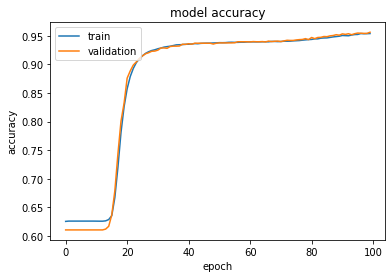

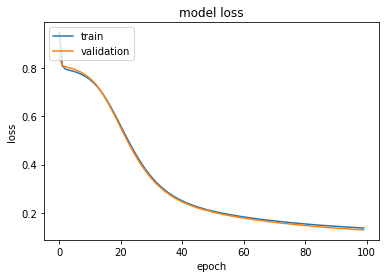

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##Test

In [15]:
dir = '/content/drive/My Drive/Quinto_Anio/TESIS_Eugenia_Berrino/DS_comp_nodef'
test_datagen = ImageDataGenerator(rescale = 1./255) 
test_batches = test_datagen.flow_from_dataframe(
    df_test, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=1,
    seed=42,
    class_mode="categorical"
    )

Found 4360 validated image filenames belonging to 3 classes.


In [16]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./04. Weights/Exp 2: Mejoras a la Clasificaciónde proyecciones/Inception_NoTL.h5')

In [17]:
#Calculamos la matriz de predicciones
result_test=model.predict(test_batches, verbose=1)
print(result_test.shape)

4360/4360 [==============================] - 2143s 491ms/step
(4360, 3)


In [18]:
pd.DataFrame(result_test).to_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/03. InceptionV3/Results/result_inception_NoTL.csv')

In [19]:
#Obtenemos el nombre de clase asociado a cada indice
classes_dict = dict(zip(train_batches.class_indices.values(),train_batches.class_indices.keys()))
classes_dict

{0: 'AP_horizontal', 1: 'L', 2: 'PA'}

In [20]:
preds_classes, gts = MyFunctions.after_test(classes_dict,result_test,test_batches)

PA               2831
L                1434
AP_horizontal      95
dtype: int64
               precision    recall  f1-score   support

AP_horizontal       0.83      0.36      0.51       217
            L       0.98      0.98      0.98      1427
           PA       0.95      0.99      0.97      2716

     accuracy                           0.96      4360
    macro avg       0.92      0.78      0.82      4360
 weighted avg       0.95      0.96      0.95      4360



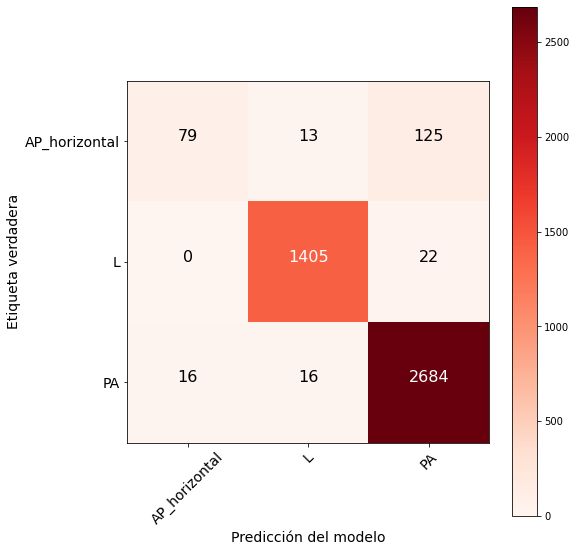

In [21]:
MyFunctions.plot_confusion_matrix(gts,preds_classes,test_batches.class_indices.keys(),
                                  path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/03. InceptionV3/Images/CM_Inception_NoTL')

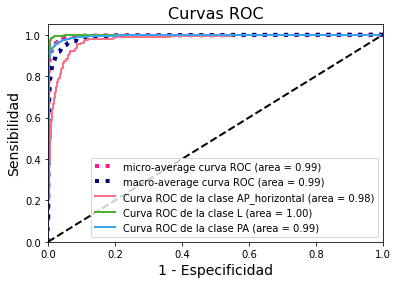

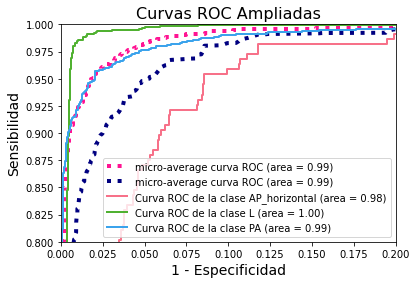

In [22]:
MyFunctions.plot_ROC(result_test,gts,NUM_CLASSES, classes_dict,
                     path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/03. InceptionV3/Images/ROC_Inception_NoTL')

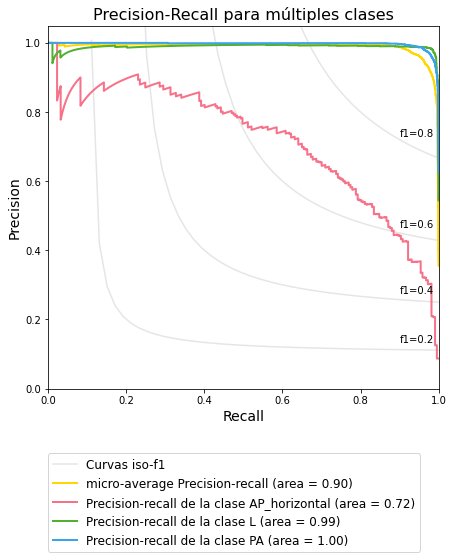

In [23]:
MyFunctions.precision_recall_many(result_test,gts,NUM_CLASSES, classes_dict,
                                  path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/03. InceptionV3/Images/PRM_Inception_NoTL')

In [24]:
df_test["Pred"] = preds_classes

In [25]:
df_test.head()

,Unnamed: 0,ImageID,ImageDir,Projection,Pred
0,0,5/117461681536540587607592076584888612953_wmoy...,5,PA,PA
1,1,0/214260817085057432303623958907855926368_jrl2...,0,PA,PA
2,2,4/144306045728819370188471558682816175107_vhmd...,4,PA,PA
3,3,1/213096160366986458367121958911602047465_wble...,1,PA,PA
4,4,4/280022667207150747197673782766436308679_15wi...,4,PA,PA


In [26]:
df_test = df_test.drop(columns=['Unnamed: 0'])

In [27]:
df_test["result"] = df_test["Projection"]==df_test["Pred"]
df_test.head()

,ImageID,ImageDir,Projection,Pred,result
0,5/117461681536540587607592076584888612953_wmoy...,5,PA,PA,True
1,0/214260817085057432303623958907855926368_jrl2...,0,PA,PA,True
2,4/144306045728819370188471558682816175107_vhmd...,4,PA,PA,True
3,1/213096160366986458367121958911602047465_wble...,1,PA,PA,True
4,4/280022667207150747197673782766436308679_15wi...,4,PA,PA,True


In [28]:
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/03. Exp 2: Mejoras a la Clasificación de Proyecciones/03. InceptionV3/Results/final_result_inception_NoTL.csv')